# Predicting Diabetes in Adults
### Ian Klasky
#### Oct 28, 2020

Diabetes is a costly diseases to both the patient, as well as our healthcare system. Cheaper and easier methods for detecting diabetes could help identify the disease earlier to improve health outcomes as well as decrease strain on our medical systems.

In this notebook we will use data from the National Health and Nutrition Examination Survey (NHANES) along with classification algorithms to predict the occurence of diabetes in adults in the United States.

The notebook is structured as follows:

* [Preprocessing](#Preprocessing)
    * [Importing Basic Packages & Data](#Importing)
    * [Feature Engineering](#Feature_Engineering)
        * [Imputation](#Imputation)
        * [Feature Selection](#Feature_Selection)
        * [Creating Dummy Variables](#Creating_Dummy_Variables)
* [Modeling](#Modeling)
    * [Logistic Regression](#Logistic)
    * [ROC / AUC](#ROC)
* [Conclusions](#Conclusions)

# Preprocessing<a name="Preprocessing"></a>

## Importing Basic Packages & Data<a name="Importing"></a>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

The CDC publishes data from it's longitudinal NHANES study on its [website](https://wwwn.cdc.gov/Nchs/Nhanes/).

For this project I used the data collected from the years 2013-2014, as the CDC created a Kaggle post and community discussion about the data from these years. This dataset can be found [here](https://wwwn.cdc.gov/Nchs/Nhanes/continuousnhanes/default.aspx?BeginYear=2013).

Of the 2013-2014 data, I only used the demographic, and questionaire information to predict patients having diabetes. I did not use other available csv's from this data set that contined the results of various medical tests and procedures, in an effort to ultimately base my predictions on readily accesible patient data, without requiring expensive tests.

In [2]:
df1 = pd.read_csv('data/demographic.csv')
df2 = pd.read_csv('data/questionnaire.csv')

df = pd.concat([df1, df2], axis=1, join='inner')

df.head()

,SEQN,SDDSRVYR,RIDSTATR,RIAGENDR,RIDAGEYR,RIDAGEMN,RIDRETH1,RIDRETH3,RIDEXMON,RIDEXAGM,...,WHD080U,WHD080L,WHD110,WHD120,WHD130,WHD140,WHQ150,WHQ030M,WHQ500,WHQ520
0,73557,8,2,1,69,NaN,4,4,1.0,NaN,...,NaN,40.0,270.0,200.0,69.0,270.0,62.0,NaN,NaN,NaN
1,73558,8,2,1,54,NaN,3,3,1.0,NaN,...,NaN,NaN,240.0,250.0,72.0,250.0,25.0,NaN,NaN,NaN
2,73559,8,2,1,72,NaN,3,3,2.0,NaN,...,NaN,NaN,180.0,190.0,70.0,228.0,35.0,NaN,NaN,NaN
3,73560,8,2,1,9,NaN,3,3,1.0,119.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0,3.0,3.0
4,73561,8,2,2,73,NaN,3,3,1.0,NaN,...,NaN,NaN,150.0,135.0,67.0,170.0,60.0,NaN,NaN,NaN


## Feature Engineering<a name="Feature_Engineering"></a>

Below we can see a histogram of number of columns in our dataframe containing various percentages of missing data. We see a large number of columns are almost completely empty.

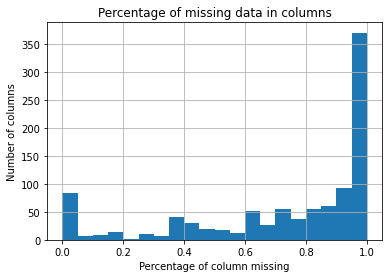

In [3]:
nas=pd.DataFrame(df.isnull().sum().sort_values(ascending=False)/len(df),columns = ['percent missing'])
pos = nas['percent missing'] > 0
nas[pos]
nas.hist(bins = 20)

plt.title('Percentage of missing data in columns')
plt.xlabel('Percentage of column missing')
plt.ylabel('Number of columns')

plt.show()

In the cells below we see the increased number of nearly complete columns when we drop the participants that are younger than 18 years old from the dataset. We removed this segment of the population because we were able to better predict the occurence of diabetes in adults without them in the dataset. Removing this segment also gave us a higher percentage of columns with no or little missing data.

In [4]:
print('Shape of DataFrame with all data: ', df.shape)
df = df.loc[(df.RIDAGEYR >= 18)]
df2 = df1
print('Shape of DataFrame with only 20 year olds and older: ', df.shape)

Shape of DataFrame with all data:  (10175, 1000)
Shape of DataFrame with only 20 year olds and older:  (6113, 1000)


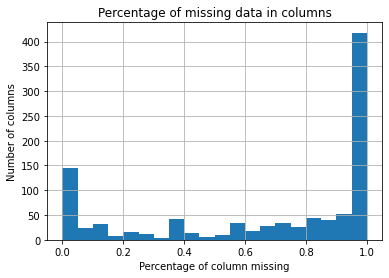

In [5]:
nas=pd.DataFrame(df.isnull().sum().sort_values(ascending=False)/len(df),columns = ['percent missing'])
pos = nas['percent missing'] > 0
nas[pos]
nas.hist(bins = 20)
acceptable_feats = nas.loc[nas['percent missing'] < 0.2]
list_acceptable_feats = list(acceptable_feats.index)

plt.title('Percentage of missing data in columns')
plt.xlabel('Percentage of column missing')
plt.ylabel('Number of columns')

plt.show()

We see that after dropping the segment of the population below the age of 18, and only taking the most complete columns, we are left with approximately 200 usable features.

The output of the following cell gives the column names, along with the column's correlation to the target variable listed from greatest to least. The top feature is the target variable - which is correlated to itself exactly how we'd expect. The next highest correlated feature only has 36% correlation. This indicates that the target isn't leaking into the other features.

In [6]:
c = df[list_acceptable_feats].corr().abs()
dc = c['DIQ010'].dropna().sort_values(kind="quicksort", ascending=False)

print(dc)

DIQ010      1.000000
DIQ160      0.363480
DIQ050      0.342668
RIDAGEYR    0.177234
MCQ365D     0.176189
              ...   
DMDBORN4    0.001508
FSDHH       0.001427
MCQ160K     0.001338
FSD032A     0.000870
CBQ535      0.000343
Name: DIQ010, Length: 203, dtype: float64


In [7]:
df = df[list_acceptable_feats]
df = df[df['DIQ010'].notna()]
df = df[df['DIQ010'] != 3]
df = df[df['DIQ010'] != 7]
df = df[df['DIQ010'] != 9]
ROO = df[df['DIQ010'] == 1].shape[0]/df.shape[0]
df['DIQ010'] = df['DIQ010'].replace({2:0})
print("Percentage of survey responders with diabetes: ", round(ROO,4)*100)

Percentage of survey responders with diabetes:  12.23


Below is the distribution of adult patients that have (1) and don't have (0) diabetes.

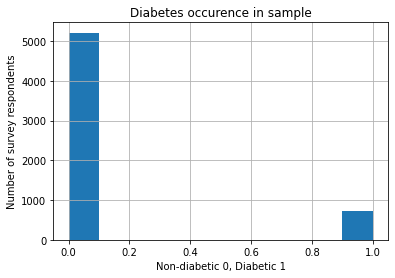

In [8]:
df['DIQ010'].hist()

plt.title('Diabetes occurence in sample')
plt.xlabel('Non-diabetic 0, Diabetic 1')
plt.ylabel('Number of survey respondents')

plt.show()

### Imputation<a name="Imputation"></a>

Below we will fill the missing data in our dataframe with the median values of the respective columns. We previously implemented a K-Nearest Neighbors algorithm to impute, but since there was little to no difference in the performance of our model we chose to use the simpler and less computationally expensive median imputation.

In [9]:
import time

tic = time.time()

col_names = list(df.columns)

print('Before imputation: ', df.isnull().sum().sum(), 'missing')

#fill na's with medians
for col in df.columns:
    df[col] = df[col].fillna((df[col].median()))
      
print('After imputation: ', df.isnull().sum().sum(), 'missing')

df.columns = col_names

toc = time.time()
print('runtime: ',toc-tic)

Before imputation:  42126 missing
After imputation:  0 missing
runtime:  0.4979429244995117


We will now drop the remainder of the directly diabetes related features from our dataframe. Although these features don't have exceptionally high correlation to the target, I don't want to use any diabetes related data in my modeling.

In [10]:
print('Shape of DataFrame before dropping unwanted features: ', df.shape)
remove_list = ['DIQ160', 'DIQ050', 'DIQ180', 'DIQ172', 'DIQ170']
keep_list = set(df.columns) - set(remove_list)
df = df[keep_list]
prefix_list = []
df = df.loc[:,~df.columns.str.startswith(tuple(prefix_list))]
print('Shape of DataFrame after dropping unwanted features: ', df.shape)

Shape of DataFrame before dropping unwanted features:  (5934, 209)
Shape of DataFrame after dropping unwanted features:  (5934, 204)


### Feature Selection<a name="Feature_Selection"></a>

We will now pare down our approximately 200 features to the most 'useful' subset by using logistic regression feature selection. After trying various numbers of features to select, 63 seemed to produce good results.

In [11]:
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression

X_fs = df.drop('DIQ010',axis=1)
y_fs = df['DIQ010']

model = LogisticRegression()
rfe = RFE(model, 63)
fit = rfe.fit(X_fs, y_fs)
print("Num Features Selected with Logistic Regression: %s" % (fit.n_features_))

Num Features Selected with Logistic Regression: 63


In [12]:
fs_results = zip(list(fit.support_),list(X_fs.columns))

selected_feats = []
for TF, col_name in fs_results:
    if TF == True:
        selected_feats.append(col_name)

### Creating Dummy Variables<a name="Creating_Dummy_Variables"></a>

Below we split our target from the the rest of our features, and create the necessary dummy variables for our dataframe.

In [13]:
X = df[selected_feats]
y = df['DIQ010']

dummy_list = []
for col in X.columns:
    if X[col].max() <= 99 and X[col].max() != 80:
        dummy_list.append(col)
X = pd.get_dummies(X, prefix=dummy_list, columns=dummy_list)

# Modeling

## Logistic Regression <a name="Logistic"></a>

We will now scale our data and split it into testing and training sets.

In [14]:
from sklearn import preprocessing
from sklearn.model_selection import train_test_split

scaler = preprocessing.StandardScaler().fit(X)
X_scaled=scaler.transform(X)
y = y.ravel()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state = 1)

We will now fit and run a logistic regression model on our remaining features to predict for diabetes.

In [15]:
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
logreg = LogisticRegression()
logreg.fit(X_train, y_train)
y_pred_lr = logreg.predict(X_test)

Below we can see our model's resulting confusion matrix. We can see that our model was able to correctly predict the occurnece of diabetes in the sample (sensitiivity) at around 2.5 times its rate of occurence. We can also see that our model predicted the patients that didn't have diabetes (specificity) with very high accuracy.

In [16]:
from sklearn.metrics import classification_report, confusion_matrix
conf_mat_lr = pd.DataFrame(confusion_matrix(y_test, y_pred_lr),columns=['pred_neg', 'pred_pos'], index=['neg', 'pos'])
print('\nConfusion matrix of Logistic Regression model\n')
print(conf_mat_lr)
print('\nSensitivity: ', round(conf_mat_lr.pred_pos[1]/(conf_mat_lr.pred_neg[1]+conf_mat_lr.pred_pos[1]),4))
print('Sensitivity / rate of occurence in sample: ', round(conf_mat_lr.pred_pos[1]/(conf_mat_lr.pred_neg[1]+conf_mat_lr.pred_pos[1])/ROO,4))
print('Specificity: ', round(conf_mat_lr.pred_neg[0]/(conf_mat_lr.pred_neg[0]+conf_mat_lr.pred_pos[0]),4))


Confusion matrix of Logistic Regression model

     pred_neg  pred_pos
neg      1259        40
pos       127        58

Sensitivity:  0.3135
Sensitivity / rate of occurence in sample:  2.5625
Specificity:  0.9692


## ROC / AUC <a name="ROC"></a>

Since we optimized our model based on the area under the reciever operating characteristic curve, we give the curve below, and can see that it has a relatively high AUC.

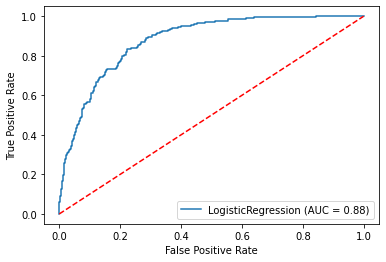

In [17]:
import sklearn.metrics as metrics
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from sklearn.metrics import plot_roc_curve
plot_roc_curve(logreg, X_test, y_test)
plt.plot([0, 1], [0, 1],'r--')
plt.show()

In [18]:
probs = pd.DataFrame(logreg.predict_proba(X_test))

In [19]:
probs['label'] = y_test
probs['pred'] = y_pred_lr

In [20]:
probs.columns = probs.columns.map(str)
probs.rename(columns={'0': "neg", '1': "pos"},inplace=True)

In [21]:
probs.sort_values(by=['pos'], axis=0, ascending=False, inplace=True,ignore_index=True)

In [22]:
from sklearn.metrics import classification_report, confusion_matrix

segments = 5

for i in range(segments):
    conf_mat_segmented = pd.DataFrame(confusion_matrix(probs.loc[(probs.pos <= (1-i*(1/segments))) & (probs.pos > (1-(1/segments)-i*(1/segments)))].label, probs.loc[(probs.pos <= (1-i*(1/segments))) & (probs.pos > (1-(1/segments)-i*(1/segments)))].pred),columns=['pred_neg', 'pred_pos'], index=['neg', 'pos'])
    print(conf_mat_segmented)

     pred_neg  pred_pos
neg         0         2
pos         0        11
     pred_neg  pred_pos
neg         0        20
pos         0        36
     pred_neg  pred_pos
neg        32        18
pos        19        11
     pred_neg  pred_pos
neg        75         0
pos        40         0
     pred_neg  pred_pos
neg      1152         0
pos        68         0


# Conclusion <a name="Conclusion"></a>

In this project we developed a model to predict the occurance of diabetes in an adult population. The logistic regression model we used performed better than, or around the same as the random forest and xgboost models we created for the same classification. We ended up choosing the logistic regression model over the others for its performance and simplicity.

We can see the model is able to predict the occurnce of diabetes in adults at a rate significantly higher than the disease's rate of occurence in the population. The fact that all three of the models we tried couldn't achieve better performance than this, indicates that the noisiness of the data could be prohibiting improved performance.